

This Notebook provide implementation of a news headline generator model using encoder decoder architecture for a given news content.
*   It uses Huggingface provided 'EncoderDecoderModel' to initialize a pretrained BERT model as encoder and decoder and further trained on the news dataset.
*   This showcases result of Bleu and Rouge2 (precision, recall,f1score) score evaluation on test dataset
*   This shows headline generation using trained model for some sample test news data record.

*   Used Decoding technique: 
    1.   Greedy Search, used for generating single headline
    2.   Beam search, used for generating multiple headline 
    3.   Beam Search with repetition penalty (for repition of ngram, used n=2), used for generating multiple relatively diverse headline


In [ ]:
'''
mount google drive
'''
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
'''
install required libraries
'''
!pip install transformers
!pip install datasets
!pip install rouge_score
!pip install sacrebleu

     |████████████████████████████████| 2.5MB 8.1MB/s 
     |████████████████████████████████| 901kB 63.0MB/s 
     |████████████████████████████████| 3.3MB 53.5MB/s 
     |████████████████████████████████| 245kB 8.1MB/s 
     |████████████████████████████████| 122kB 59.2MB/s 
     |████████████████████████████████| 245kB 56.6MB/s 
     |████████████████████████████████| 61kB 4.7MB/s 


In [ ]:
'''
import required packages
'''
from datasets import Dataset
import datasets
from transformers import BertTokenizerFast
from transformers import EncoderDecoderModel
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

import pandas as pd
import numpy as np

import random

In [ ]:
'''
pandas configuration for showing complete content of record
'''
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

In [ ]:
'''
load news data and show some sample record
'''
data_path='/content/gdrive/My Drive/Capstone_Project/Data/News_Data/news_article_with_sim_score.df'
article_df=pd.read_pickle(data_path)
print('News Article Dataframe shape: ',article_df.shape)
print('*********** sample records ***********')
article_df.sample(2)

News Article Dataframe shape:  (3000, 9)
*********** sample records ***********


,article_url,headline,content,author,published_date,read_more_source,similar_headline,similar_headline_url,similarity_scores
1912,https://inshorts.com/en/news/i-was-offered-johns-parmanu-but-i-turned-it-down-himanshi-khurana-1614262680794,I was offered John's 'Parmanu' but I turned it down: Himanshi Khurana,"Former Bigg Boss contestant Himanshi Khurana revealed that she was offered to play John Abraham's wife in 2018 film 'Parmanu: The Story of Pokhran'. ""I was not able to believe it...I was thinking...why would somebody offer this role to someone from Punjab?"" she said, adding, ""My mind was puzzled...and I said no. But later I came to know...opportunity was real.""",None,2021-02-25T14:18:00.000Z,Hindustan Times,"[Himanshi Khurana Reveals The Reason Behind Turning Down John Abraham's Parmanu, Himanshi Khurana Revealed She Passed Up An Offer To Star Opposite John Abraham In Parmanu; Find Out Why, Himanshi Khurana: 'I Was Offered John Abraham's Parmanu But I Lost It Thinking The Offer Is Unreal', Here Is Why Himanshi Khurana Rejected Bollywood film Opposite John Abraham, Himanshi Khurana Reveals The Reason Behind Turning Down John Abraham's Parmanu]","[https://www.filmibeat.com/television/news/2021/himanshi-khurana-reveals-the-reason-behind-turning-down-john-abraham-parmanu-310432.html, https://www.desimartini.com/news/martini-shots/trending/himanshi-khurana-revealed-she-passed-up-an-offer-to-star-opposite-john-abraham-in-parmanu-find-out-why-article176052.htm, https://www.spotboye.com/television/television-news/himanshi-khurana-i-was-offered-john-abraham-s-parmanu-but-i-lost-it-thinking-the-offer-is-unreal-exclusive-video/60375c7e8110c7652e25d91e, https://kiddaan.com/here-is-why-himanshi-khurana-rejected-bollywood-film-opposite-john-abraham/, https://www.ethicaleditor.com/entertainment/himanshi-khurana-reveals-the-reason-behind-turning-down-john-abrahams-parmanu/]","[0.5, 0.55, 0.64, 0.38, 0.5]"
2280,https://inshorts.com/en/news/india-reports-13742-new-covid19-cases-104-deaths-in-24-hours-1614145110407,"India reports 13,742 new COVID-19 cases, 104 deaths in 24 hours","India has reported 13,742 new COVID-19 cases and 104 fatalities in the last 24 hours, as per the Union Health Ministry. With this, the country's total cases rose to 1,10,30,176, while the death toll reached 1,56,567. As many as 14,037 patients were discharged in a day, taking the total recoveries to 1,07,26,702. Active cases now stand at 1,46,907.",None,2021-02-24,Twitter,"[India reports 13 742 new COVID 19 cases 104 deaths in last 24 hours-ANI, \n covid-19: Covid-19: India records 13,742 new cases, 104 fresh fatalities, Health News, ET HealthWorld, Latest News Highlights: India Records 13,742 New Infections, 104 Deaths In 24 Hours, \r\n\tIndia reports 13,742 new COVID cases, 104 deaths\r\n, Covid surge: India reports 13,742 infections, 104 deaths in 24 hours, COVID-19: India records 13,742 new cases, 104 fresh fatalities, India reports 13,742 new COVID-19 cases, 104 deaths in last 24 hours, COVID-19: India reports 13,742 cases, 104 deaths, India reports 13,742 new COVID-19 cases, 104 deaths in last 24 hours, COVID-19 latest updates: India reports 13,742 new cases, 104 fresh fatalities in last 24 hours]","[http://www.businessworld.in/article/India-reports-13-742-new-COVID-19-cases-104-deaths-in-last-24-hours/24-02-2021-381060, https://health.economictimes.indiatimes.com/news/diagnostics/covid-19-india-records-13742-new-cases-104-fresh-fatalities/81185204, https://www.ndtv.com/india-news/todays-latest-and-breaking-news-live-updates-on-coronavirus-and-farmers-protest-24-february-2021-2377240, http://www.uniindia.com/news/india/india-reports-13-742-new-covid-cases-104-deaths/2327100.html, https://www.business-standard.com/article/current-affairs/covid-surge-india-reports-13-742-infections-104-deaths-in-24-hours-121022400314_1.html, https://www.thehindu.com/news/national/covid-19-india-records-13742-new-cases-104-fresh-fatalities/article33920403.ece, https://www.an

In [ ]:
'''
converting existing one-to-many mapping to one-to-one mapping
'''
contents=[]
headlines=[]
similarity_scores=[]
count=0
for index, row in article_df.iterrows():
  contents.append(row['content'])
  headlines.append(row['headline'])
  similarity_scores.append(1.0)
  for similar_headline,similarity_score in zip(row['similar_headline'],row['similarity_scores']):
    contents.append(row['content'])
    headlines.append(similar_headline)
    similarity_scores.append(similarity_score)

print('no of records in training dataset: ',len(headlines))

no of records in training dataset:  23363


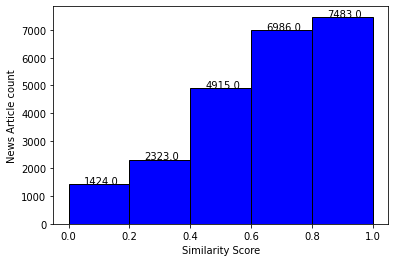

In [ ]:
'''
plotting similarity scrore distribution of similar headline with respect to reference headline
'''
import matplotlib.pyplot as plt
%matplotlib inline

plt.clf
#plt.hist(similarity_scores, bins=5,  edgecolor="black", color="blue") #normed=True, 
counts, bins, _=plt.hist(similarity_scores, bins=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],  edgecolor="black", color="blue") #normed=True, bins=[140, 150, 160, 175, 185, 200],
plt.ylabel('News Article count')
plt.xlabel('Similarity Score')
for count, bin in zip(counts, bins):
        plt.gca().text(bin + 0.05, count, str(count))  # +0.05 to center text

plt.show()

In [ ]:
'''
decide threshold for min and max no-of-word-token in headline 
'''
headline_len=[len(headline.split(" ")) for headline in headlines]
print('5th percentile length: ',np.quantile(headline_len, 0.05))
print('25th percentile length: ',np.quantile(headline_len, 0.25))
print('50th percentile length: ',np.quantile(headline_len, 0.50))
print('75th percentile length: ',np.quantile(headline_len, 0.75))
print('95th percentile length: ',np.quantile(headline_len, 0.95))
print('99th percentile length: ',np.quantile(headline_len, 0.99))

5th percentile length:  3.0
25th percentile length:  9.0
50th percentile length:  11.0
75th percentile length:  14.0
95th percentile length:  19.0
99th percentile length:  23.0


In [ ]:
'''
filtering news record based on similarity score and no-of-word-token in the headline
'''
min_word_token_in_headline=5
max_word_token_in_headline=16
min_similarity_score=0.5
summaries=[]
art_headlines=[]
for content,headline,similarity_score in zip(contents,headlines,similarity_scores):
   if(similarity_score>min_similarity_score):
     headline_len=len(headline.split(' '))
     if(min_word_token_in_headline <= headline_len <= max_word_token_in_headline):
      summaries.append(content)
      art_headlines.append(headline)

In [ ]:
'''
creating summary-headline pair and then randomly shuffle them
'''
summary_headline_pairs=list(zip(summaries,art_headlines))
random.shuffle(summary_headline_pairs)
len(summary_headline_pairs)

15306

In [ ]:
'''
get train and test dataset
'''
train_summary_headline_pairs=summary_headline_pairs[0:8000]# it should have been 0:13500. training is taking more than 14 hour that's why having 8000 train record
test_summary_headline_pairs=summary_headline_pairs[13500:]
no_of_training_records=len(train_summary_headline_pairs)


In [ ]:
'''
get a basic understanding of Huggingface dataset (creation from a dictionary, way it stores record)
'''
df = pd.DataFrame({"a": [1, 2, 3]})
huggingface_dataset = Dataset.from_pandas(df)
print('sample record: ',huggingface_dataset[0])
print('record count: ',len(huggingface_dataset))
print(huggingface_dataset)

sample record:  {'a': 1}
record count:  3
Dataset({
    features: ['a'],
    num_rows: 3
})


In [ ]:
'''
transform training news data in to huggingface dataset format
'''
summaries=[summary_headline_tuple[0] for summary_headline_tuple in train_summary_headline_pairs]
headlines=[summary_headline_tuple[1] for summary_headline_tuple in train_summary_headline_pairs]
summary_headline_map={"summary":summaries,"headline":headlines}
train_hf_dataset = Dataset.from_dict(summary_headline_map)

In [ ]:
'''
transform test news data in to huggingface dataset format
'''
test_summaries=[summary_headline_tuple[0] for summary_headline_tuple in test_summary_headline_pairs]
test_headlines=[summary_headline_tuple[1] for summary_headline_tuple in test_summary_headline_pairs]
test_summary_headline_map={"summary":test_summaries,"headline":test_headlines}
test_hf_dataset = Dataset.from_dict(test_summary_headline_map)# test dataset

In [ ]:
'''
show sample summary and headline record from huggingface dataset
'''
print('******** sample record *******')
train_hf_dataset[3]
# type(train_hf_dataset) #datasets.arrow_dataset.Dataset

******** sample record *******


{'headline': 'Justin Hartley and Chrishell Stause Finalize Divorce',
 'summary': "'This Is Us' star Justin Hartley and his estranged wife Chrishell Stause have reportedly finalised their divorce. According to reports, Justin and Chrishell had signed on their final divorce documents earlier this month. The former couple had tied the knot on October 28, 2017, and split up two years later after Justin filed for divorce in November 2019."}

In [ ]:
train_hf_dataset

Dataset({
    features: ['summary', 'headline'],
    num_rows: 8000
})

In [ ]:
'''
instantiate tokenizer
'''
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [ ]:
'''
generate stats of the dataset such as summary length,headline length,  no of summaries with token size greater than 512 etc.
'''
def map_to_length(x):
  x["summary_len"] = len(tokenizer(x["summary"]).input_ids)
  x["article_longer_512"] = int(x["summary_len"] > 512)
  x["headline_len"] = len(tokenizer(x["headline"]).input_ids)
  x["headline_longer_64"] = int(x["headline_len"] > 64)
  x["headline_longer_128"] = int(x["headline_len"] > 128)
  return x

def compute_and_print_stats(x):
  if len(x["summary_len"]) == no_of_training_records:
    print('maximum summary length ',max(x["summary_len"]))
    print('maximum headline length ',max(x["headline_len"]))
    print('average summary length ',sum(x["summary_len"])/no_of_training_records)
    print('average headline length ',sum(x["headline_len"])/no_of_training_records)
    print('headline longer than 128 ',sum(x["headline_longer_64"]))
    print('headline longer than 128 ',sum(x["headline_longer_128"]))

data_stats = train_hf_dataset.map(map_to_length)
output = data_stats.map(compute_and_print_stats, batched=True, batch_size=-1,) #batch size -1 means all record in the dataset will batched together for map call

maximum summary length  125
maximum headline length  36
average summary length  82.812125
average headline length  18.41725
headline longer than 128  0
headline longer than 128  0



In [ ]:
'''
define preprocessing step applied to training data
'''

encoder_max_length = 125 #deciding based on previous cell output('maximum summary length')
decoder_max_length = 40 #deciding based on previous cell output('maximum headline length')

def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer(batch["summary"], padding="max_length", truncation=True, max_length=encoder_max_length)
  outputs = tokenizer(batch["headline"], padding="max_length", truncation=True, max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["decoder_input_ids"] = outputs.input_ids
  batch["decoder_attention_mask"] = outputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()
  # In 🤗Transformers loss of the padded labels can be ignore by setting the label to -100
  batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]
  return batch
  

In [ ]:
'''
pre-process huggingface datset
'''
batch_size=16

train_data = train_hf_dataset.map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    remove_columns=["summary", "headline"]
)

In [ ]:
train_data

Dataset({
    features: ['attention_mask', 'decoder_attention_mask', 'decoder_input_ids', 'input_ids', 'labels'],
    num_rows: 8000
})

In [ ]:
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

In [ ]:
train_data

Dataset({
    features: ['attention_mask', 'decoder_attention_mask', 'decoder_input_ids', 'input_ids', 'labels'],
    num_rows: 8000
})

In [ ]:
'''
sample training record
'''
train_data[3]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]),
 'decoder_attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'decoder_input_ids': tensor([  101,  6796, 20955,  1998,  3782, 18223,  2358, 20559,  2063,  2345,
          4697,  8179,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'input_ids': tensor([  101,  1005,  2023,  20

In [ ]:
'''
load encoder decoder model using pretrained weights
'''
bert2bert = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relations

In [ ]:
'''
set configurations
'''
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token

bert2bert.config.decoder_start_token_id = tokenizer.bos_token_id
bert2bert.config.eos_token_id = tokenizer.eos_token_id
bert2bert.config.pad_token_id = tokenizer.pad_token_id

bert2bert.config.vocab_size = bert2bert.config.decoder.vocab_size

print('BOS token is: ',bert2bert.config.decoder_start_token_id)
print('PAD token is: ',bert2bert.config.pad_token_id)
print('EOS token is: ',bert2bert.config.eos_token_id)
print('vocab size is: ',bert2bert.config.vocab_size)

BOS token is:  101
PAD token is:  0
EOS token is:  102
vocab size is:  30522


In [ ]:
'''
parameters for beam search---By defualt max size of generated sequence will be 20
'''
bert2bert.config.no_repeat_ngram_size = 3
bert2bert.config.early_stopping = True
bert2bert.config.length_penalty = 2.0
bert2bert.config.num_beams = 4
'''

In [ ]:
'''
load rouge metric for validation
'''
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [ ]:
'''
set training arguments
'''

training_args = Seq2SeqTrainingArguments(
    output_dir="./",
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    logging_steps=1000,  
    save_steps=500,  
    eval_steps=8000, 
    warmup_steps=2000,  
    #max_steps=16,
    num_train_epochs=2,
    overwrite_output_dir=True,
    save_total_limit=3,
    fp16=False,#True 
)

'''
instantiate trainer
'''
trainer = Seq2SeqTrainer(
    model=bert2bert,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=train_data,
)


In [ ]:
'''
train the bert2bert model
'''
trainer.train()

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


TrainOutput(global_step=1000, training_loss=6.37593603515625, metrics={'train_runtime': 35480.192, 'train_samples_per_second': 0.451, 'train_steps_per_second': 0.028, 'total_flos': 3918236034240000.0, 'train_loss': 6.37593603515625, 'epoch': 2.0})

In [ ]:
'''
save the trained model to drive
'''
bert2bert.save_pretrained("/content/gdrive/My Drive/Capstone_Project/saved_trained_model/headline_generator_encoder_decoder_model/19june/bert2bert_based_mdel")

In [ ]:
'''
load the model from drive
'''
saved_model_path="/content/gdrive/My Drive/Capstone_Project/saved_trained_model/encoder_decoder_without_pretrained_embedding/19june/bert2bert_based_mdel"
bert2bert_model = EncoderDecoderModel.from_pretrained(saved_model_path)

In [ ]:
'''
generate/infer headline from news-summary
'''
batch_size = 4

def generate_headline(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    # cut off at BERT max length 512
    inputs = tokenizer(batch["summary"], padding="max_length", truncation=True, max_length=encoder_max_length, return_tensors="pt")
    input_ids = inputs.input_ids#.to("cuda")
    attention_mask = inputs.attention_mask #.to("cuda")

    outputs = bert2bert_model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch



In [ ]:
'''
generating News Headline for News stories used in training 
'''
evaluation_dataset = train_hf_dataset.select([record_index for record_index in range(12)])
len(evaluation_dataset)
results = evaluation_dataset.map(generate_headline, batched=True, batch_size=batch_size)#, remove_columns=["article"]

pred_str = results["pred"]
label_str = results["headline"]

rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

print(rouge_output)


Score(precision=0.03571428571428571, recall=0.027574277574277575, fmeasure=0.030555555555555558)


In [ ]:
results[0]

{'headline': 'Surat Court Acquits 122 Persons Accused of Being SIMI Members',
 'pred': 'delhi court grants bail to 8 accused of covid - 19 cases',
 'summary': "A court in Gujarat's Surat on Saturday acquitted 122 persons arrested under The Unlawful Activities (Prevention) Act for participating in a meeting organised here in December 2001 as members of the banned outfit Students Islamic Movement of India (SIMI). A total of 127 people were arrested in this case, of which five had reportedly died while the trial was pending."}

In [ ]:
'''
generating News Headline for test News stories (these news-stories didn't got used in training) 
'''
test_evaluation_dataset = test_hf_dataset.select([record_index for record_index in range(12)])
len(test_evaluation_dataset)
test_results = test_evaluation_dataset.map(generate_headline, batched=True, batch_size=batch_size) 

test_pred_str = test_results["pred"]
test_label_str = test_results["headline"]

rouge_output = rouge.compute(predictions=test_pred_str, references=test_label_str, rouge_types=["rouge2"])["rouge2"].mid

print(rouge_output)


Score(precision=0.04924242424242425, recall=0.03706293706293706, fmeasure=0.041967291967291966)


In [ ]:
test_results[0]

{'headline': "Hong Kong leader, top officials get China's Sinovac vaccine",
 'pred': "india's first covid - 19 vaccine receives covaxin",
 'summary': "Hong Kong's leader Carrie Lam and other government officials received China's Sinovac COVID-19 vaccine on Monday. Sinovac is the first COVID-19 vaccine to be introduced in Hong Kong, which will soon be followed by Pfizer/BioNTech vaccine before February-end, reported Reuters. The city is set to begin its vaccine program on Friday with medical workers, the elderly, caretakers being the priority."}

In [ ]:
for index in range(12):
  print('*********************************')
  print('actual headline: ',test_results[index]['summary'])
  print('actual headline: ',test_results[index]['headline'])
  print('predicted headline: ',test_results[index]['pred'])

*********************************
actual headline:  Hong Kong's leader Carrie Lam and other government officials received China's Sinovac COVID-19 vaccine on Monday. Sinovac is the first COVID-19 vaccine to be introduced in Hong Kong, which will soon be followed by Pfizer/BioNTech vaccine before February-end, reported Reuters. The city is set to begin its vaccine program on Friday with medical workers, the elderly, caretakers being the priority.
actual headline:  Hong Kong leader, top officials get China's Sinovac vaccine
predicted headline:  india's first covid - 19 vaccine receives covaxin
*********************************
actual headline:  Divya Dureja is a Delhi-based psychologist who has been accused by a 28-year-old French woman of sexually harassing her in a Goa hotel room. The 27-year-old is known to be an LGBTQI+ activist, slam poet and TEDx speaker. According to her Facebook profile, she's also the co-founder of Performers' Consortium, a platform for nourishing artists and de

In [ ]:
'''
calculate rouge2 score(precision, recall, fmeasure) for 1806 test samples
'''
len(test_hf_dataset)#1806
test_results = test_hf_dataset.map(generate_headline, batched=True, batch_size=batch_size) 

test_pred_str = test_results["pred"]
test_label_str = test_results["headline"]

rouge_output = rouge.compute(predictions=test_pred_str, references=test_label_str, rouge_types=["rouge2"])["rouge2"].mid

print(rouge_output)


Score(precision=0.044589730486618434, recall=0.03505699236290909, fmeasure=0.03839466703205903)


In [ ]:
'''
calculate bleu score for 1806 test samples
'''
sacrebleu = datasets.load_metric("sacrebleu")
#print(sacrebleu)
#Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
#Produces BLEU scores along with its sufficient statistics from a source against one or more references.

test_label_as_list_of_list=[[label_str]for label_str in test_label_str]
sacrebleu_output = sacrebleu.compute(predictions=test_pred_str, references=test_label_as_list_of_list)
print('sacrebleu_output: ',sacrebleu_output)
print('bleu score: ',sacrebleu_output['score'])

sacrebleu_output:  {'score': 0.7401589357148857, 'counts': [1896, 243, 55, 16], 'totals': [18495, 16689, 14883, 13077], 'precisions': [10.251419302514194, 1.456048894481395, 0.36954915003695493, 0.12235222145752084], 'bp': 0.8166086593300528, 'sys_len': 18495, 'ref_len': 22242}
bleu score:  0.7401589357148857


In [ ]:
'''
generate multiple headline for given news story using beam search
'''
num_beams=5
def generate_headline_beam(batch):
    inputs = tokenizer(batch["summary"], padding="max_length", truncation=True, max_length=encoder_max_length, return_tensors="pt")# Tokenizer will automatically set [BOS] <text> [EOS]
    input_ids = inputs.input_ids#.to("cuda")
    attention_mask = inputs.attention_mask #.to("cuda")
    beam_output = bert2bert_model.generate(input_ids, attention_mask=attention_mask, num_beams=num_beams, num_return_sequences=5, early_stopping=True)
    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(beam_output, skip_special_tokens=True)
    no_of_sample_in_batch=len(batch["summary"])#3
    op_str_beam=[]
    for index in range(no_of_sample_in_batch):
      #print((index*num_beams,(index+1)*num_beams))
      op_str_beam.append(output_str[index*num_beams:(index+1)*num_beams])
    batch["pred"] = op_str_beam
    return batch

In [ ]:
'''
generating multiple News Headline for test News stories using beam search
'''
test_evaluation_dataset = test_hf_dataset.select([record_index for record_index in range(9,12)])
len(test_evaluation_dataset)
test_results_beam = test_evaluation_dataset.map(generate_headline_beam, batched=True, batch_size=batch_size) 
for index in range(3):
  print('*********************************')
  print('actual headline: ',test_results_beam[index]['summary'])
  print('actual headline: ',test_results_beam[index]['headline'])
  print('predicted headline: ',test_results_beam[index]['pred'])



*********************************
actual headline:  The Mayor of the French city of Nice, Christian Estrosi, has urged visitors to stay away from the tourist hotspot as the city battles a spike in COVID-19 infections. He added that new measures that "go beyond the nationwide 6 pm curfew" were needed to tackle the surge in cases. "A weekend lockdown would make sense," Estrosi said.
actual headline:  French City of Nice Asks Tourists to Stay Away amid COVID Surge
predicted headline:  ['covid - 19 toll toll tolls spike to 1, 000 people', 'covid - 19 toll toll tolls spike to 1, 000', 'covid - 19 toll toll tolls spike to over 1, 000', 'covid - 19 toll toll tolls spike to 20 %', 'covid - 19 toll toll tolls spike in africa']
*********************************
actual headline:  Bengali actress Srabanti Chatterjee joined the Bharatiya Janata Party (BJP) on Monday, ahead of Assembly elections in the state. She joined the saffron party in the presence of BJP national general secretary Kailash Vij

In [ ]:
'''
generate multiple headline for given news story using beam search with repetition penalty
'''
num_beams=5
def generate_headline_beam_with_repitition_penalty(batch):
    inputs = tokenizer(batch["summary"], padding="max_length", truncation=True, max_length=encoder_max_length, return_tensors="pt")# Tokenizer will automatically set [BOS] <text> [EOS]
    input_ids = inputs.input_ids#.to("cuda")
    attention_mask = inputs.attention_mask #.to("cuda")
    beam_output = bert2bert_model.generate(input_ids, attention_mask=attention_mask, num_beams=num_beams, num_return_sequences=5, no_repeat_ngram_size=2, early_stopping=True)
    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(beam_output, skip_special_tokens=True)
    no_of_sample_in_batch=len(batch["summary"])#3
    op_str_beam=[]
    for index in range(no_of_sample_in_batch):
      #print((index*num_beams,(index+1)*num_beams))
      op_str_beam.append(output_str[index*num_beams:(index+1)*num_beams])
    batch["pred"] = op_str_beam
    return batch

In [ ]:
'''
generating multiple News Headline for test News stories using beam search with repetition penalty
'''
test_evaluation_dataset = test_hf_dataset.select([record_index for record_index in range(9,12)])
len(test_evaluation_dataset)
test_results_beam = test_evaluation_dataset.map(generate_headline_beam_with_repitition_penalty, batched=True, batch_size=batch_size) 
for index in range(3):
  print('*********************************')
  print('actual headline: ',test_results_beam[index]['summary'])
  print('actual headline: ',test_results_beam[index]['headline'])
  print('predicted headline: ',test_results_beam[index]['pred'])



*********************************
actual headline:  The Mayor of the French city of Nice, Christian Estrosi, has urged visitors to stay away from the tourist hotspot as the city battles a spike in COVID-19 infections. He added that new measures that "go beyond the nationwide 6 pm curfew" were needed to tackle the surge in cases. "A weekend lockdown would make sense," Estrosi said.
actual headline:  French City of Nice Asks Tourists to Stay Away amid COVID Surge
predicted headline:  ['covid - 19, 000 people die in africa', 'covid - 19, 000 people live in africa', 'covid - 19, 000 people die in haiti', 'covid - 19 toll tolls spike in africa', 'covid - 19, 000 people die']
*********************************
actual headline:  Bengali actress Srabanti Chatterjee joined the Bharatiya Janata Party (BJP) on Monday, ahead of Assembly elections in the state. She joined the saffron party in the presence of BJP national general secretary Kailash Vijayvargiya and the party's state president, Dilip 